### Metadata

In [1]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor
from Preprocessing.time_series_preprocessing import read_static, read_features
from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np
import random
import tensorflow as tf
import torch

def set_all_seeds(seed):
    """
    Set seed for reproducibility in different libraries.
    :param seed: An integer representing the seed value.
    """
    random.seed(seed)  # Python's built-in random module
    np.random.seed(seed)  # Numpy library
    os.environ['PYTHONHASHSEED'] = str(seed)  # Environment variable

    # TensorFlow
    tf.random.set_seed(seed)
    if tf.__version__[0] == '2':
        # For TensorFlow 2.x, additionally set the global random seed
        tf.compat.v1.set_random_seed(seed)
    
    # PyTorch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        # If using GPU with PyTorch, set additional seeds
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # for multi-GPU

##### Constants

In [2]:
""" Read Dataset:"""
DIR_PATH = 'External_Val/data'
file = 'dataset.csv'
file_path = os.path.join(DIR_PATH, file)

""" Dataset Preprocessing:"""
train_percentage = 80
T = 3
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

seed = 1
n_tests = 3

### Read and Preprocess the Data

#### Read the Data

In [3]:
# Read dataset
dengue_df = pd.read_csv(file_path)
dengue_df

,0,1,2,3,4,5,6,7,8,9,...,1020,1021,1022,1023,Epiweek,precipitation,population,variation,temperature,cases
0,0.241374,-1.561932,0.309142,0.761763,1.078860,1.038276,-2.130718,0.208693,1.016787,-0.113562,...,0.359771,0.134949,-0.437693,1.264120,201601,0.439,1.294546e+07,0.900000,30.026000,495.0
1,-0.135461,-1.707807,-0.354339,0.824970,-1.381245,-0.742811,-0.288823,0.445895,-0.027824,-1.365176,...,-1.010611,0.023148,0.860643,-0.245002,201602,120.388,1.294769e+07,0.900000,27.062500,404.0
2,-2.683568,1.224843,0.817149,-0.550825,-0.816751,1.652855,-0.524891,0.929462,-0.728161,-0.589060,...,0.675015,-1.634904,-0.782346,-2.879396,201603,16.389,1.294992e+07,0.900000,27.203714,420.0
3,-0.392921,0.414659,0.140102,-1.350422,-0.746271,-0.540469,0.311457,1.756462,0.112347,-0.115989,...,-0.140753,1.145457,-0.880416,-0.794366,201604,27.539,1.295215e+07,0.900000,32.608786,421.0
4,1.538756,-0.343051,0.173756,0.301466,-1.253962,0.681083,0.404304,1.364242,0.577944,1.022846,...,-0.134025,1.979926,-1.624665,-1.132198,201605,0.000,1.295438e+07,0.900000,34.180857,468.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,1.244006,-0.590205,1.047149,0.202036,-2.700557,-0.005340,1.109713,-1.685690,1.490114,0.629420,...,-1.558685,-0.126284,0.180389,0.005462,202348,4.456,1.372091e+07,0.687736,27.412054,510.0
412,0.386444,0.995367,-0.079516,0.315029,3.171045,0.049635,0.460055,1.517618,0.447097,-1.374521,...,1.056130,-1.314655,-0.968883,2.481470,202349,33.037,1.372268e+07,0.688302,27.412054,636.0
413,-0.663760,-0.805401,0.189657,1.455089,0.259192,-1.646903,-0.912002,-0.322412,-0.162563,-0.678678,...,-0.105960,-1.564262,0.753925,-2.086452,202350,0.323,1.372445e+07,0.688868,27.412054,816.0
414,-1.707962,-0.988960,-0.488344,-0.919691,-1.072049,1.122650,0.170106,1.359195,-1.414566,0.916261,...,0.629730,-0.115686,0.213907,0.221282,202351,13.727,1.372623e+07,0.689434,27.412054,721.0


#### Train-Test Split

In [4]:
train_df, test_df = train_test_split(dengue_df, train_percentage)

The train shape is: (332, 1030)
The test shape is: (84, 1030)


#### Normalize the Data

In [5]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)

train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1020,1021,1022,1023,Epiweek,precipitation,population,variation,temperature,cases
0,0.287921,-1.580927,0.285642,0.830261,1.122717,1.038938,-2.276310,0.106338,1.066391,-0.174982,...,0.361783,0.179263,-0.408517,1.186723,-1.604674,-0.780605,-1.866384,0.973599,0.625412,0.902618
1,-0.110402,-1.733129,-0.361763,0.892562,-1.398430,-0.764283,-0.266453,0.330736,-0.022448,-1.493603,...,-0.937545,0.070421,0.833807,-0.212375,-1.599246,3.197937,-1.854182,0.973599,-0.139644,0.647117
2,-2.803806,1.326711,0.781340,-0.463503,-0.819929,1.661155,-0.524049,0.788200,-0.752437,-0.675938,...,0.660682,-1.543763,-0.738300,-2.654707,-1.593817,-0.251565,-1.841981,0.973599,-0.103188,0.692040
3,-0.382543,0.481390,0.120697,-1.251634,-0.747700,-0.559427,0.388566,1.570558,0.123658,-0.177539,...,-0.112788,1.163036,-0.832139,-0.721687,-1.588389,0.118265,-1.829779,0.973599,1.292182,0.694848
4,1.659281,-0.309183,0.153535,0.376565,-1.267988,0.677306,0.489879,1.199511,0.608969,1.022265,...,-0.106409,1.975427,-1.544279,-1.034889,-1.582961,-0.795166,-1.817577,0.973599,1.698027,0.826810


In [6]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
#test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1020,1021,1022,1023,Epiweek,precipitation,population,variation,temperature,cases
332,0.844819,0.101891,-0.664210,0.148358,-1.717373,-0.195394,1.097222,-0.676304,-1.286415,-1.311516,...,-0.388372,-1.781685,1.787905,1.519812,1.760782,-0.795166,1.615759,-0.991473,-0.700624,0.296154
333,-2.301854,-0.071911,-1.204043,-0.286773,-0.149240,0.411207,1.292022,1.586020,0.514027,0.458447,...,-0.326024,0.606340,-0.375369,1.464744,1.766210,0.262216,1.625226,-0.988468,-0.445470,0.158576
334,0.340395,0.933796,-0.052099,0.189967,0.512572,0.938956,-0.674293,1.362327,-0.327199,0.652417,...,0.300065,0.786657,-0.553729,1.166862,1.771638,-0.353857,1.634692,-0.985464,-1.246650,0.046268
335,-0.312066,-1.310045,0.149862,0.405677,0.381393,0.794086,-1.973591,0.713620,0.071676,0.032001,...,-0.129671,-0.615866,1.416554,-2.155533,1.777067,-0.326858,1.644159,-0.982459,-1.276080,-0.161502
336,1.171915,-0.351888,1.640901,-0.406599,0.286998,-0.809491,1.761473,-0.988366,0.647049,0.819793,...,0.678145,-0.018265,0.972665,0.657464,1.782495,-0.175079,1.653626,-0.979454,-1.085503,-0.127810


#### Prepare data for time series supervised learning (function to create sliding window)

In [7]:
ar = True
# frame as supervised learning
train = series_to_supervised(train_df, n_in=T, autoregressive=ar)
test = series_to_supervised(test_df, n_in=T, autoregressive=ar)

train.shape

(329, 4120)

#### Features and Labels Set

In [8]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df, autoregressive=ar)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df, autoregressive=ar)

Train:
The shape of the features is (329, 3090)
The shape of the labels is (329, 1)
Test:
The shape of the features is (81, 3090)
The shape of the labels is (81, 1)


In [9]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, ar)

The initial shapes are:
The train shape is (329, 3090)
The test shape is (81, 3090)
-----------------------
The Final shapes are:
The train shape is (329, 3, 1030)
The test shape is (81, 3, 1030)


### Joint Fusion Model

In [10]:
if T != 0: 
    sequence=train_X.shape[1]
else:
    sequence=T

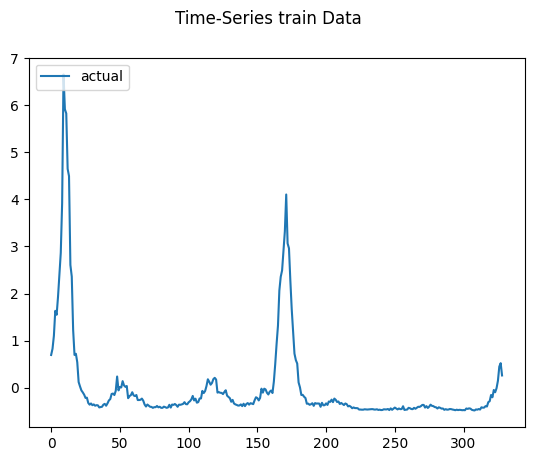

2024-02-21 19:14:27.433313: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-02-21 19:14:27.433347: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-02-21 19:14:27.433351: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-02-21 19:14:27.433893: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-21 19:14:27.434305: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 1000)           4028000   
                                                                 
 lstm_1 (LSTM)               (None, 500)               3002000   
                                                                 
 batch_normalization (Batch  (None, 500)               2000      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 250)               125250    
                                                                 
 batch_normalization_1 (Bat  (None, 250)               1000      
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 120)               3

2024-02-21 19:14:33.974824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-21 19:14:34.991833: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-21 19:14:35.006715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-21 19:14:35.079628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-21 19:14:35.240107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-21 19:14:36.088182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-21 19:14:36.230891: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 4.
Epoch 12: early stopping
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 lstm_input (InputLayer)     [(None, 3, 6)]               0         []                            
                                                                                                  
 lstm_2_input (InputLayer)   [(None, 3, 1024)]            0         []                            
                                                                                                  
 sequential_2 (Sequential)   (None, 120)                  7188850   ['lstm_input[0][0]']          
                                                                                                  
 sequential_3 (Sequential)   (None, 120)                  1126085   ['lstm_2_input[0][0]']        
          

2024-02-21 19:15:05.826385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-21 19:15:06.213322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-21 19:15:06.226086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-21 19:15:06.239786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-21 19:15:06.297859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-21 19:15:06.383675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-21 19:15:06.477332: I tensorflow/core/grappler/optimizers/cust

3/3 [==============================] - 2s 224ms/step
Test MAE: 184.845
Test RMSE: 270.111
Test sMAPE: 79.767
Test R Squared: 0.105
{'mae': 184.8445852950767, 'rmse': 270.1110150354921, 'smape': 79.76656629560625, 'r2': 0.10535168446435761}


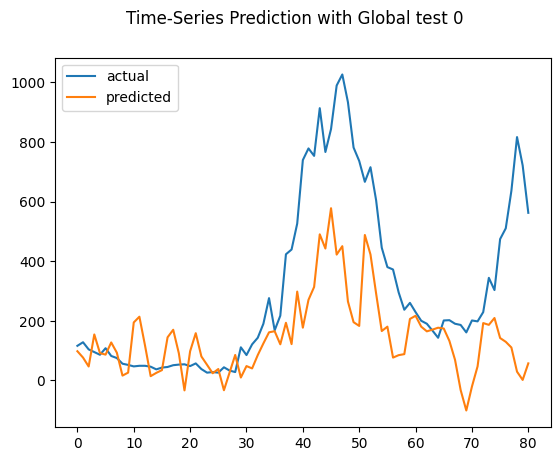

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 3, 1000)           4028000   
                                                                 
 lstm_5 (LSTM)               (None, 500)               3002000   
                                                                 
 batch_normalization_6 (Bat  (None, 500)               2000      
 chNormalization)                                                
                                                                 
 dense_12 (Dense)            (None, 250)               125250    
                                                                 
 batch_normalization_7 (Bat  (None, 250)               1000      
 chNormalization)                                                
                                                                 
 dense_13 (Dense)            (None, 120)              

2024-02-21 19:15:16.119072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-21 19:15:16.983901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-21 19:15:16.985435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-21 19:15:17.002297: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-21 19:15:17.002767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-21 19:15:17.149811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-21 19:15:17.181396: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 20.
Epoch 28: early stopping
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 lstm_4_input (InputLayer)   [(None, 3, 6)]               0         []                            
                                                                                                  
 lstm_6_input (InputLayer)   [(None, 3, 1024)]            0         []                            
                                                                                                  
 sequential_6 (Sequential)   (None, 120)                  7188850   ['lstm_4_input[0][0]']        
                                                                                                  
 sequential_7 (Sequential)   (None, 120)                  1126085   ['lstm_6_input[0][0]']        
       

2024-02-21 19:16:04.010830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-21 19:16:04.572719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-21 19:16:04.587141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-21 19:16:04.601096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-21 19:16:04.618822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-21 19:16:04.714066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-21 19:16:04.748540: I tensorflow/core/grappler/optimizers/cust

3/3 [==============================] - 4s 683ms/step
Test MAE: 165.524
Test RMSE: 203.871
Test sMAPE: 65.446
Test R Squared: 0.490
{'mae': 165.52406664247866, 'rmse': 203.8707996042137, 'smape': 65.4456369146065, 'r2': 0.4903432138735281}


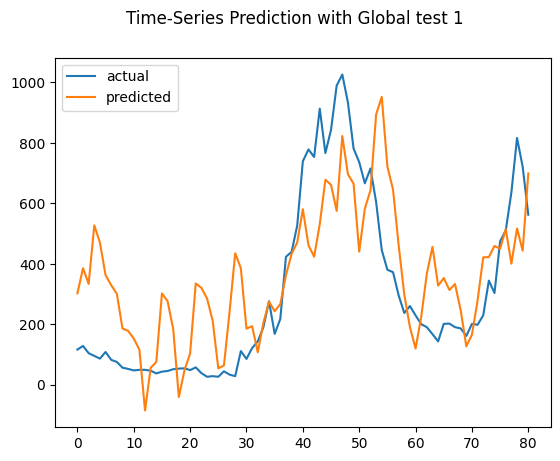

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 3, 1000)           4028000   
                                                                 
 lstm_9 (LSTM)               (None, 500)               3002000   
                                                                 
 batch_normalization_12 (Ba  (None, 500)               2000      
 tchNormalization)                                               
                                                                 
 dense_24 (Dense)            (None, 250)               125250    
                                                                 
 batch_normalization_13 (Ba  (None, 250)               1000      
 tchNormalization)                                               
                                                                 
 dense_25 (Dense)            (None, 120)              

2024-02-21 19:16:20.445004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-21 19:16:21.393187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-21 19:16:21.406623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-21 19:16:21.409357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-21 19:16:21.540408: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-21 19:16:21.563282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-21 19:16:21.787268: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 12.
Epoch 20: early stopping
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 lstm_8_input (InputLayer)   [(None, 3, 6)]               0         []                            
                                                                                                  
 lstm_10_input (InputLayer)  [(None, 3, 1024)]            0         []                            
                                                                                                  
 sequential_10 (Sequential)  (None, 120)                  7188850   ['lstm_8_input[0][0]']        
                                                                                                  
 sequential_11 (Sequential)  (None, 120)                  1126085   ['lstm_10_input[0][0]']       
       

2024-02-21 19:16:56.421958: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-21 19:16:56.859631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-21 19:16:56.874105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-21 19:16:56.888991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-21 19:16:56.926927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-21 19:16:57.010698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-21 19:16:57.105921: I tensorflow/core/grappler/optimizers/cust

3/3 [==============================] - 3s 251ms/step
Test MAE: 180.906
Test RMSE: 234.188
Test sMAPE: 74.277
Test R Squared: 0.327
{'mae': 180.90599206053182, 'rmse': 234.18809215522367, 'smape': 74.27676736560946, 'r2': 0.32749212251444815}


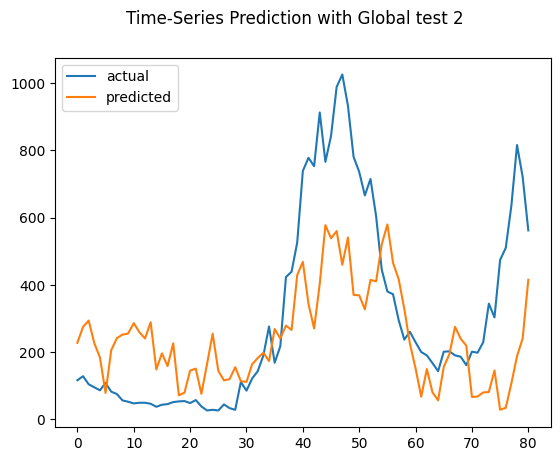

rmse : average=236.057, std=27.075
mae : average=177.092, std=8.336
smape : average=73.163, std=5.899
r2 : average=0.308, std=0.158


([236.05663559830978, 27.074712999950933],
 [177.0915479993624, 8.335990158071219],
 [73.16299019194074, 5.899301047770244],
 [0.30772900695077793, 0.15779217340495752])

In [11]:
set_all_seeds(1)

x_ar = train_X[:, :, :1024]
x_ar_test = test_X[:, :, :1024]
train_X = train_X[:, :, 1024:]
test_X = test_X[:, :, 1024:]

calculate_mean_std(lstm_layers, nn_layers, sequence, train_X.shape[2], dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_cases'], monitor=True, plot=None, epochs=50, batch_size=16, n_tests=n_tests, plot_samples=True, Municipality='Global', fusion='joint', x_ar=x_ar, x_ar_test=x_ar_test)